In [1]:
# Resolve path when used in a usecase project
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../../").resolve()))

# Advanced html reports functionality

After a report structure is created (see tutorial), this how-to guide explains how to add advanced customization when rendering the report as an html file.

### Adding Metadata to Report

Metadata can be used to provide additional information about the report.

We use `title` (sets up the first header) and `creation_time` (shown in the top right corner) parameters by default. If `creation_time` is not passed, it will be evaluated automatically.

You can pass any extra parameters if you want to use additional metadata. They will be passed to jinja template. The only thing left is to use those in template somehow. Please see `Changing Report Appearance` section for details.

In [2]:
# here we provide title of the report 

meta_data = {
    "title": "Mill Features Overview",
}

In [3]:
from reporting.datasets import get_mill_data
from reporting.reports import plot_feature_overviews
from reporting.rendering.html import generate_html_report


report_figs = plot_feature_overviews(
    data=get_mill_data(),
    features=[
        "mill_a_power",
        "mill_a_load",
    ],
    timestamp="time_col",
)

generate_html_report(
    report_structure=report_figs,
    report_meta_data=meta_data,
    render_path="./report_examples/updating_meta.html",
)

In [4]:
!open ./report_examples/updating_meta.html

### Adding Sections Descriptions

Users can provide additional description. That will be displayed as a hovering text block for a given section.

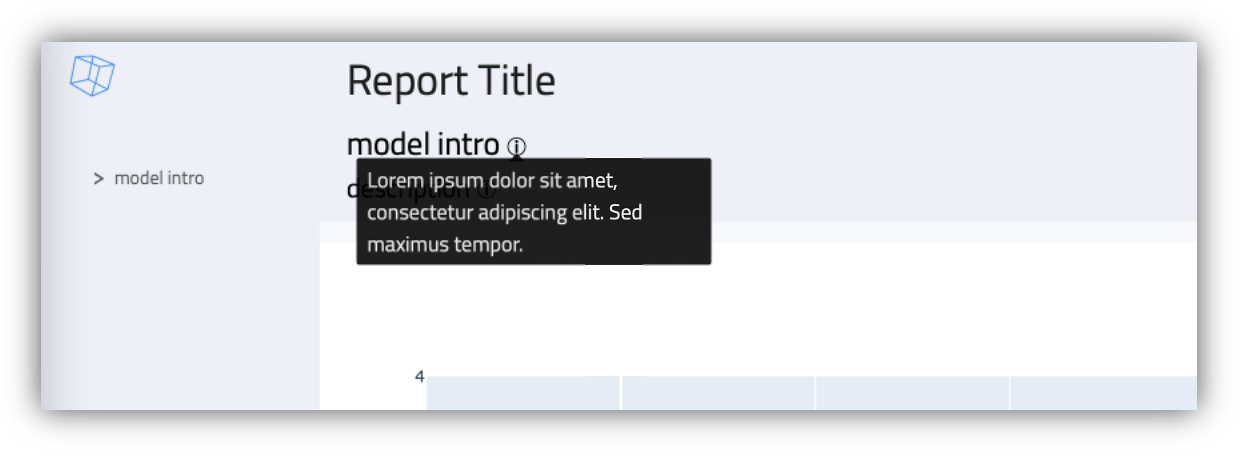

In [5]:
descriptions = {
    # this is a validation section description
    # note that key is a tuple
    ('model intro', ): 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed maximus tempor.',

    # this identifies the description for section `description` 
    # which is a sub section of `model intro`
    ('model intro', 'description'): 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed maximus tempor.',
}

In [6]:
import plotly.graph_objects as go
from reporting.rendering.html import generate_html_report

# mock report structure
fig = go.Figure()
report_structure = {
    'model intro': {
        'description': fig,
        'target': [fig, fig],
        'features': [fig, fig, fig],
    },
}

# generate report
generate_html_report(
    report_structure=report_structure,
    sections_description=descriptions,
    render_path="./report_examples/adding_descriptions.html",
)

In [7]:
!open ./report_examples/adding_descriptions.html

### Advanced Configuration of Report

#### Changing Report Appearance

Currently report generation can be split into two parts: 
1. rendering `figures` argument input
2. generating report

At first step we create a `reporting.rendering.html.rendering.Rendering` – an object that stores rendered objects (figures and headers) and table of contents for them.

Then using that rendering and jinja template we create the report. Inside template we just call `to_html()` method for each of our `HtmlRenderableObject`.

To update plot's appearance users can provide another template. **This will require knowledge of HTMl and CSS** (optionally JS if one wants to add some kind of animation).

Users can modify HTML template to fullfil their needs, for example add info about file's author. 

This html is rendered using `jinja` which opens up a way for various flexible ways to build a report. Users can provide new template using `report_template_path` argument. 

To get default template users can use `TemplateWithCodeHighlighter`. Once init, this class contains HTML source code of template as well as other assets.

Let's load it, save into the file and then edit.

In [8]:
# get the default HTML template with its assets

from pathlib import Path
from reporting.rendering.html import TemplateWithCodeHighlighter

template = TemplateWithCodeHighlighter()

template_dir = Path("template")
template_dir.mkdir(exist_ok=True)  # create this new directory
template_path = template_dir / "template.html"
template_path.write_text(template.source)  # save template source
for asset, asset_source in template.assets.items():
    (template_dir / asset).write_text(asset_source, encoding='utf-8')  # save each asset source

Now we can update this template in our prefered IDE. 

Mostly all updates have to be done in `contents` (at the bottom of the template). 

In this example we will add new metadata with report's author i.e. block `<p>{{ meta.author }}</p>` that uses new metadata's parameter `author`.
```HTML
    <div class="contents">
        <div class="report-header">
            <h1 class="report-title">{{ meta.title }}</h1>
            
            <!-- NEW CODE LINE ------>
            <p>{{ meta.author }}</p>
            <!----------------------->
            
            <p class="report-date">{{ meta.creation_time }}</p>
        </div>
        {% for obj in render %}
            {{ obj.to_html(previous_item=loop.previtem, next_item=loop.nextitem) }}
        {% endfor %}
    </div>
```

In [9]:
# We will do those changes programatically

old_template = template_path.read_text()
insert_position = old_template.find('<p class="report-date">')
new_string = '<p>{{ meta.author }}</p>'
new_template = (
    old_template[:insert_position]
    + new_string
    + old_template[insert_position:]
)

template_path.write_text(new_template);

To provide updated template to the reporting function use `generate_html_report` argument.

In [10]:
from reporting.datasets import get_mill_data
from reporting.reports import plot_feature_overviews
from reporting.rendering.html import generate_html_report


report_figs = plot_feature_overviews(
    data=get_mill_data(),
    features=[
        "mill_a_power",
        "mill_a_load",
    ],
    timestamp="time_col",
)

generate_html_report(
    report_structure=report_figs,
    report_meta_data={
        'title': 'Mill Report',
        'author': 'OAI team',  # don't forget to pass this new metadata parameter
    },
    render_path="./report_examples/updating_template.html",
    report_template_path=template_path,
)

Note the author name at the top of report added

In [11]:
!open ./report_examples/updating_template.html

#### Controlling Headers Rendering Depth

##### Reducing

Remember, each key of the input's nested dict becomes a header in the report. And sometimes we have exssesive nesting, for example:

```python
report_structure = {
    'validation approach': {
        'period': {
            'train': {
                'old plant setup': fig,
                'updated plant setup': fig,
            },
            'test': {
                'old plant setup': fig,
                'updated plant setup': fig,
            },
        },
        'visual representation': [fig, fig, fig, fig],
    },
}
```

Imagine we want only to show **first three levels** of keys as headers. Keys that are deeper in the structure will not be shown as headers but all the **plots will be shown**. I.e. for section `validation approach` we'll have four sub headers: `period`, `train`, `test` and `visual representation`.

**Desired behaviour**

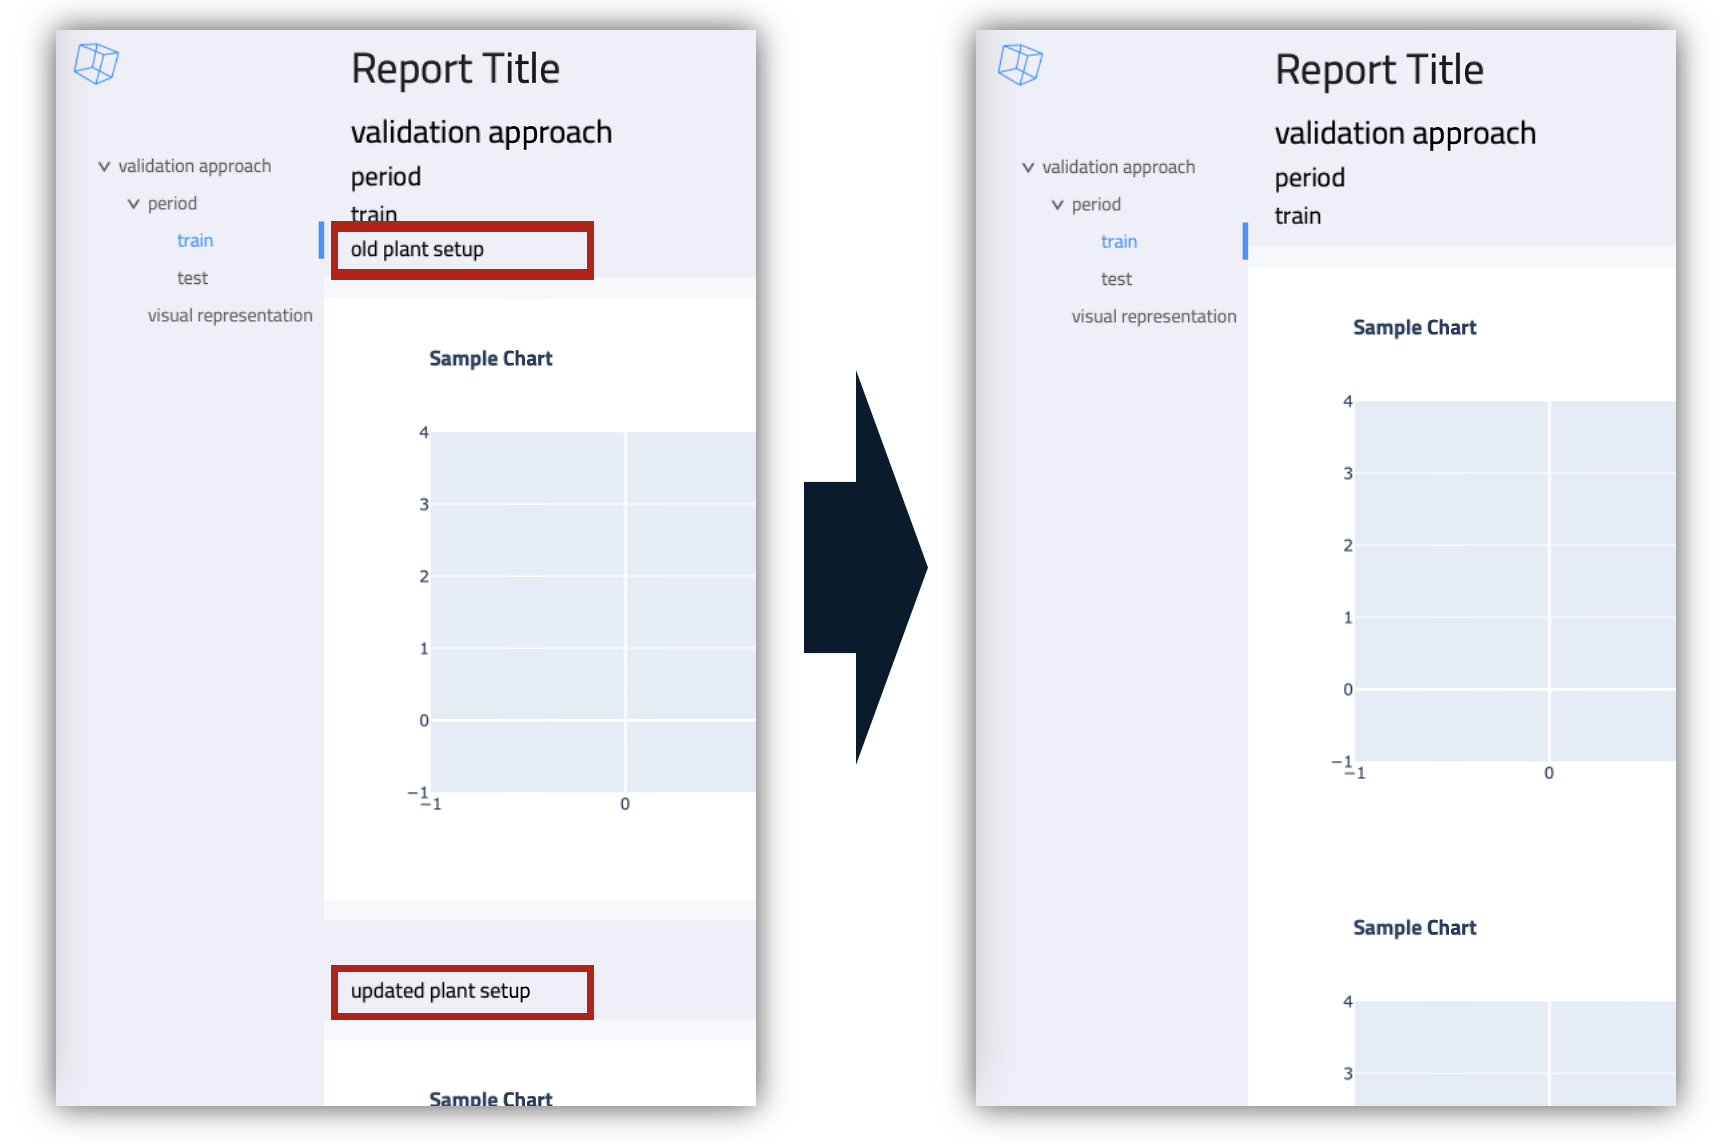

To control headers that are shown in the content section, update `max_level_of_header` argument.

However, even if it might be tempting to create very informative nested structure, we encourage you to create reports with third level of nesting at most to make reports simpler to understand.

To limit resulting structure to 3 levels set `max_level_of_header` to `3`.

In [17]:
import plotly.graph_objects as go
from reporting.rendering.html import generate_html_report


# mock report structure
fig = go.Figure(layout=dict(title='Sample Chart'))
report_structure = {
    'validation approach': {
        'period': {
            'train': {
                'old plant setup': fig,
                'updated plant setup': fig,
            },
            'test': {
                'old plant setup': fig,
                'updated plant setup': fig,
            },
        },
        'visual representation': [fig, fig, fig, fig],
    },
}

# generate report
generate_html_report(
    report_structure=report_structure,
    render_path="./report_examples/rendering_depth_reducing.html",
    max_level_of_header=3,  # reduces max header level
)

In [18]:
!open ./report_examples/rendering_depth_reducing.html

##### Increasing

Sometimes the report structure is very complex and it's easier to understand having all possible header levels rendered. 

In case you want to render all possible headers in the report set `max_level_of_header` to `None`.

Note that we need to update table of contents depth separatelly. Please refer to the next section `controlling the table of contents (TOC) depth` section.

**Desired behaviour**

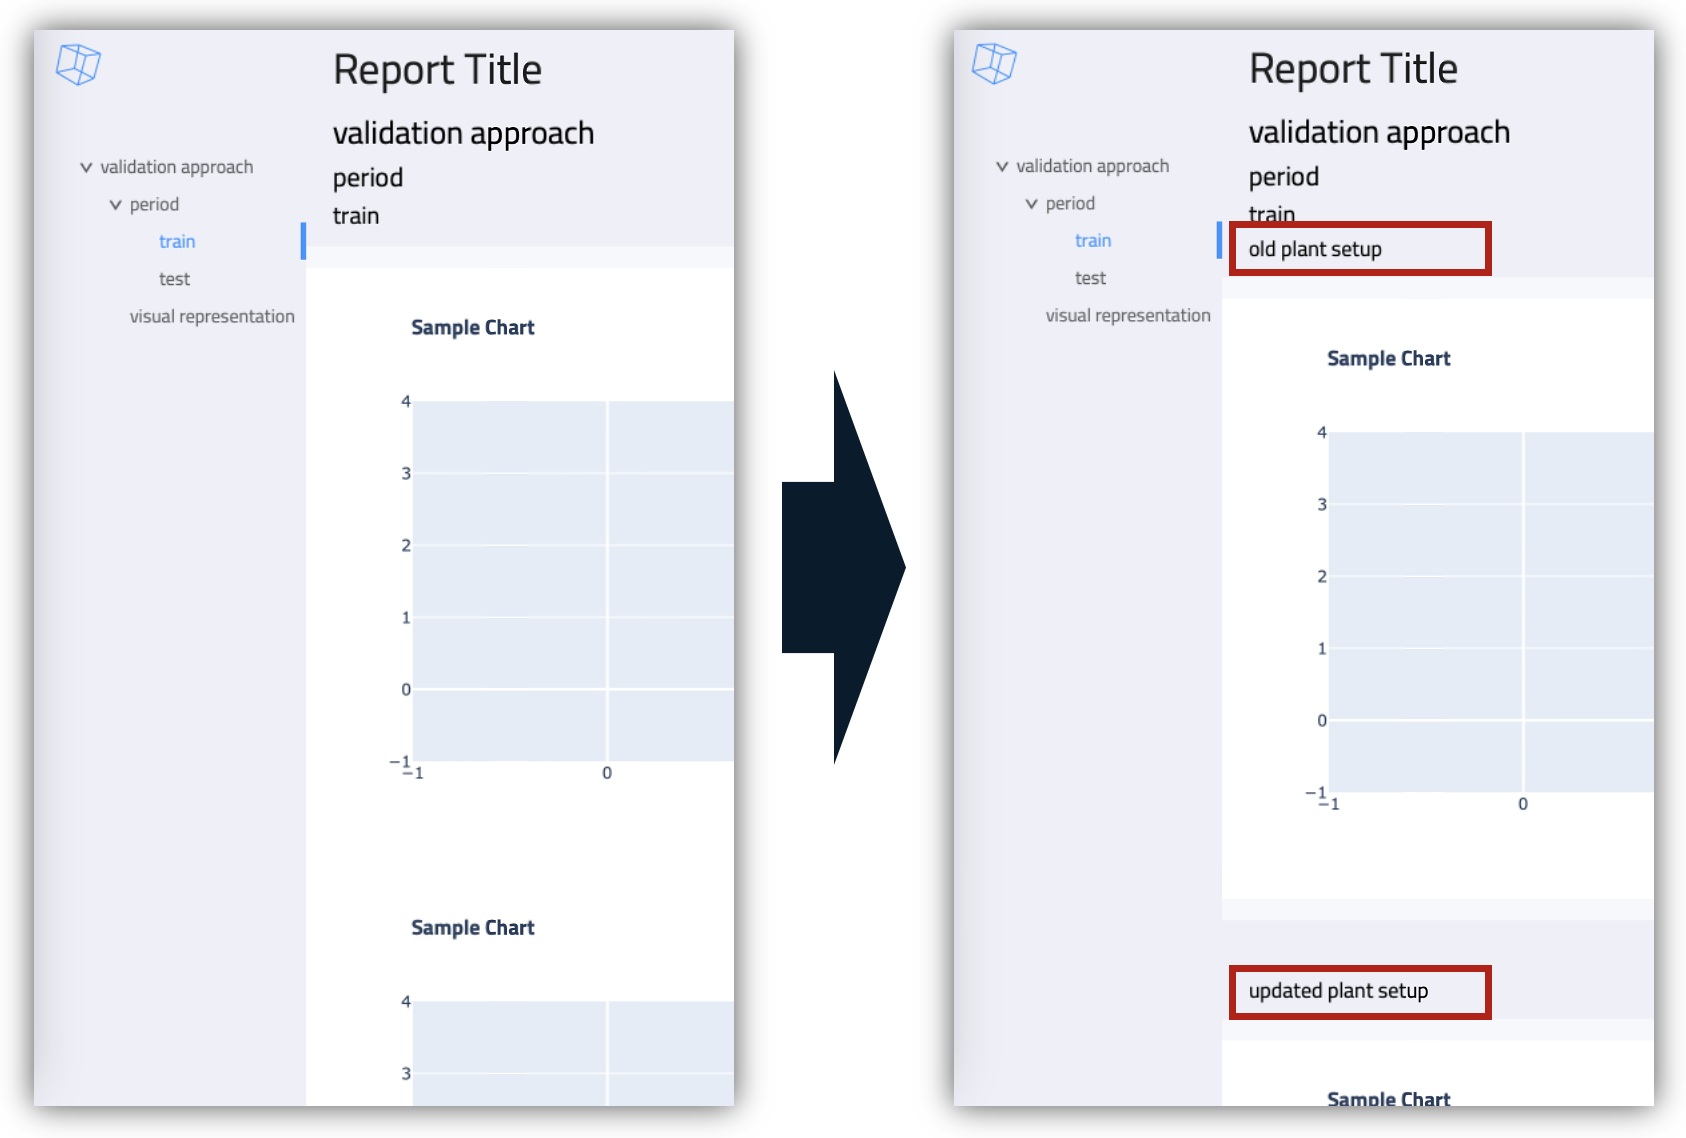

In [19]:
import plotly.graph_objects as go
from reporting.rendering.html import generate_html_report


# mock report with heavily nested structure
fig = go.Figure(layout=dict(title='Sample Chart'))
report_structure = {
    'validation approach': {
        'period': {
            'train': {
                'old plant setup': fig,
                'updated plant setup': fig,
            },
            'test': {
                'old plant setup': fig,
                'updated plant setup': fig,
            },
        },
        'visual representation': [fig, fig, fig, fig],
    },
}

# generate report
generate_html_report(
    report_structure=report_structure,
    render_path="./report_examples/rendering_depth_increasing.html",
    max_level_of_header=None,  # render all levels of headers
)

In [20]:
!open ./report_examples/rendering_depth_increasing.html

#### Controlling the Table of Contents (TOC) Depth

Controlling TOC helps to mimimise the amount of elements in navigation bar. However this makes navigation more complicated. We recommend to create reports with no more than 3 level TOC.

To control the depth of table of content on the left of the report, use argument `max_table_of_content_depth`. If `None` provided, then all the levels will be shown. Levels enumeration starts with 1 and goes up with depth.

##### Reducing

In this example we will be showing only the first level of our menu by setting `max_table_of_content_depth=1`.

**Desired behaviour**

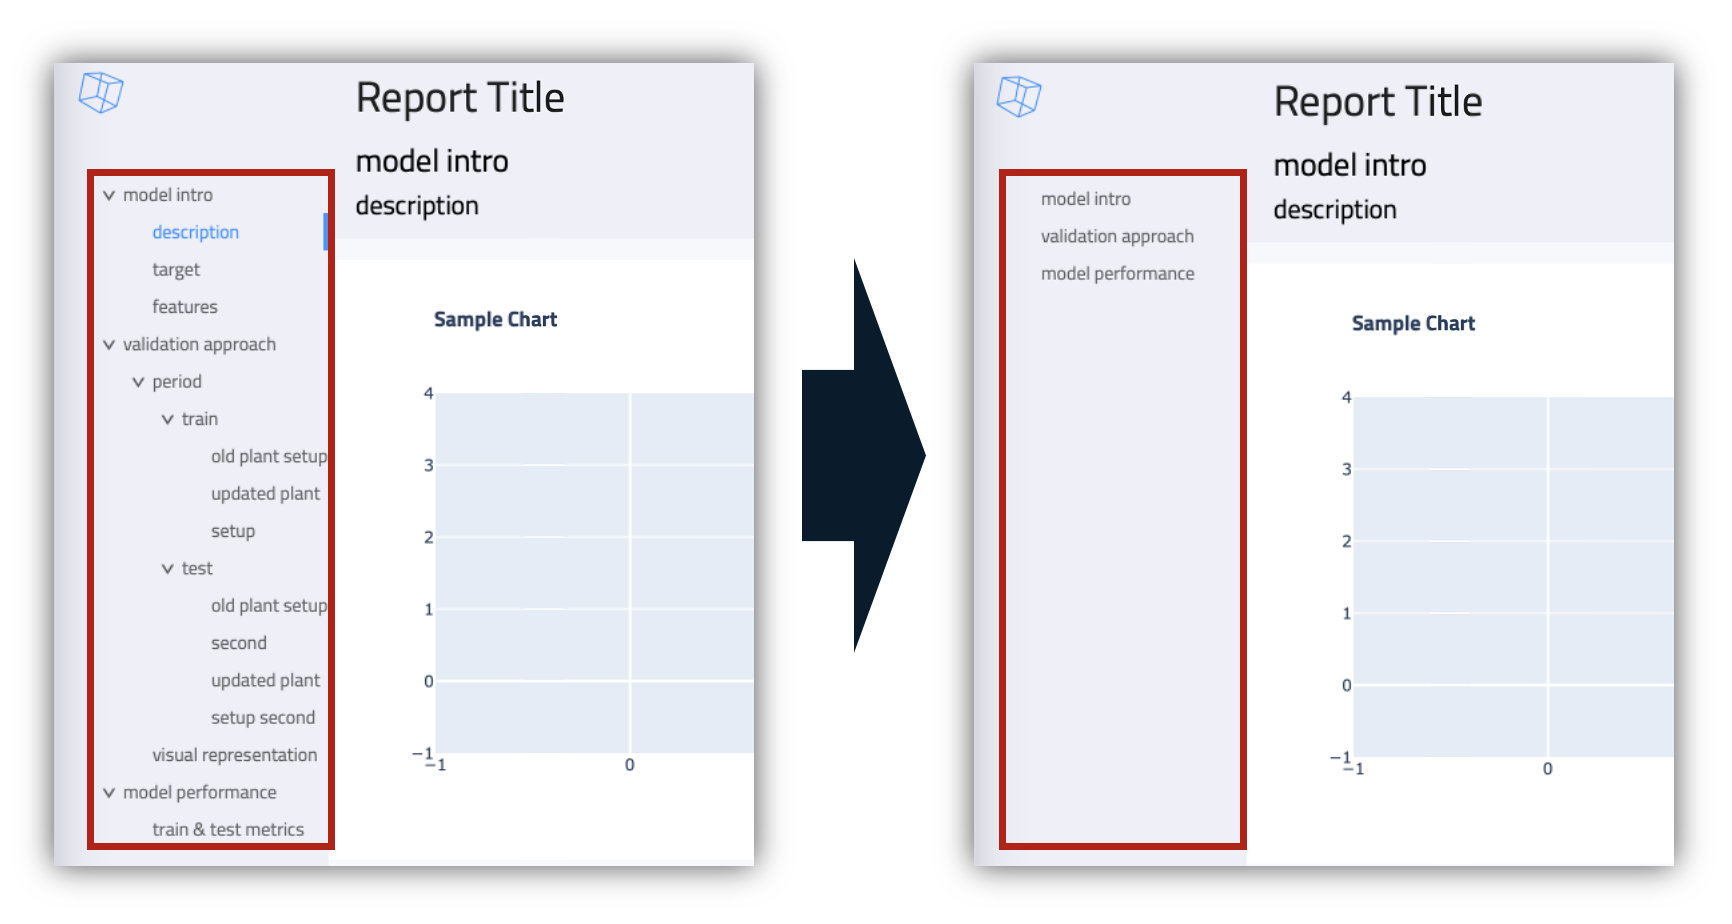

In [21]:
import plotly.graph_objects as go
from reporting.rendering.html import generate_html_report


# mock report with heavily nested structure
fig = go.Figure(layout=dict(title='Sample Chart'))
report_structure = {
    'model intro': {
        'description': fig,
        'target': [fig, fig],
        'features': [fig, fig, fig],
    },
    'validation approach': {
        'period': fig,
        'visual representation': [fig, fig, fig, fig],
    },
    'model performance': {
        'train & test metrics': [fig, fig, fig]
    },
}

# generate report
generate_html_report(
    report_structure=report_structure,
    render_path="./report_examples/toc_depth_control_reducing.html",
    max_table_of_content_depth=1,  # show only 1st level of TOC
)

In [22]:
!open ./report_examples/toc_depth_control_reducing.html

##### Increasing

It's also useful sometimes to show more elements in the TOC. This can be done by setting `max_table_of_content_depth` to the desired depth. If set to `None`, then all elements are shown. Remember to render proper depth of headers, we'll be setting `max_level_of_header = None` to render all levels of headers to demonstrate TOC control.

**Desired behaviour**

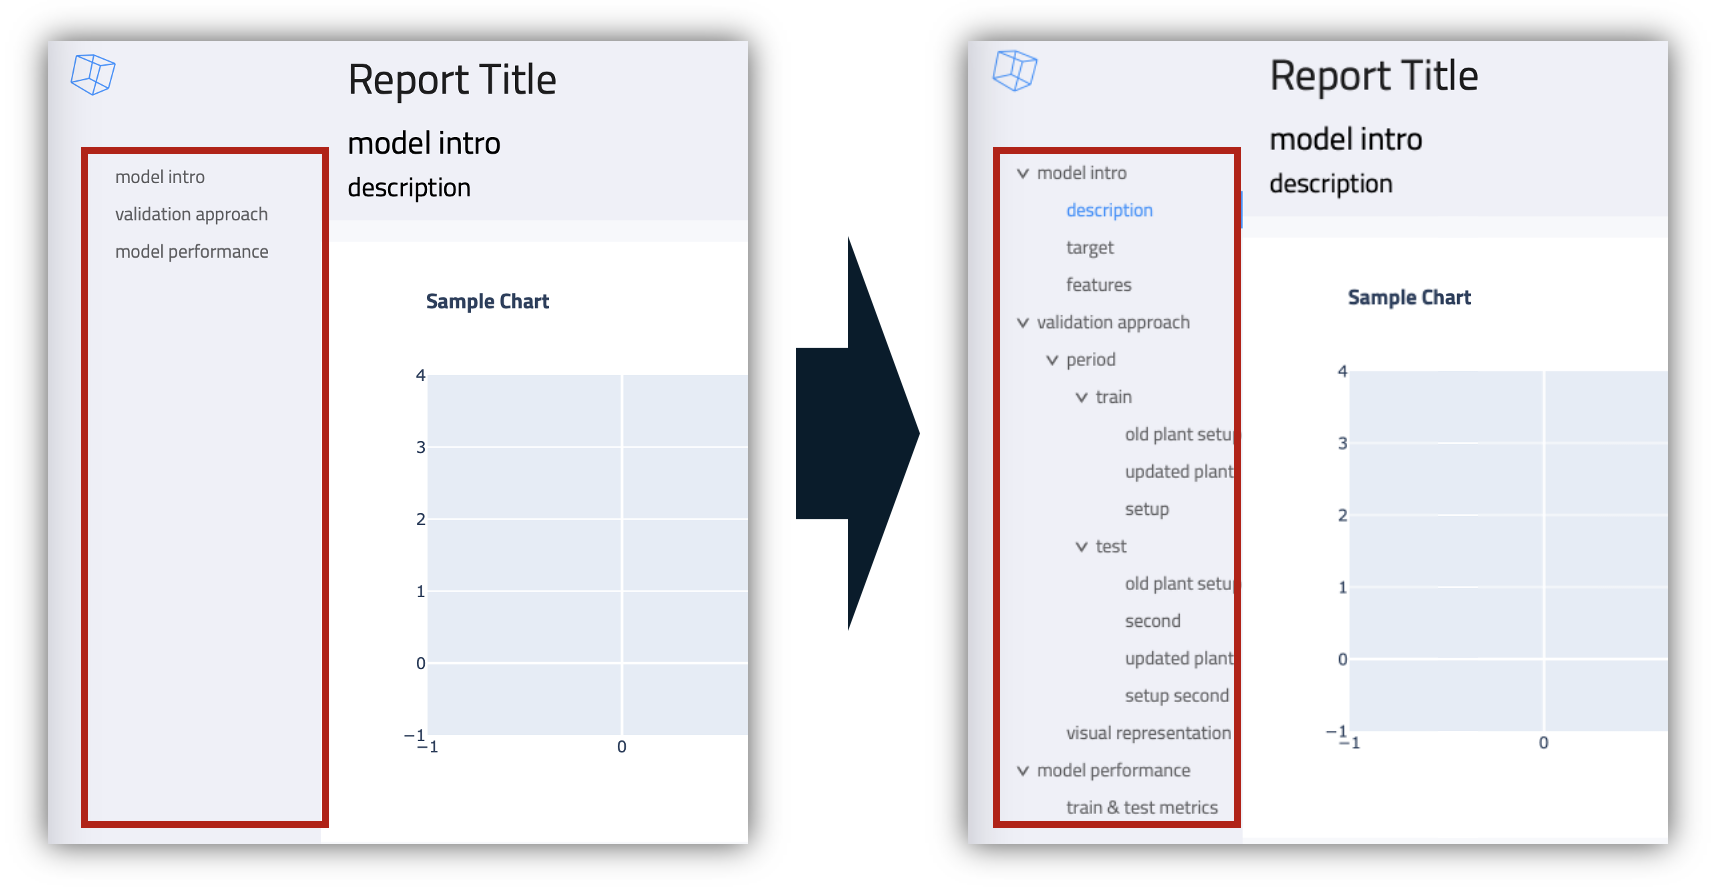

In [23]:
import plotly.graph_objects as go
from reporting.rendering.html import generate_html_report


# mock report with heavily nested structure
fig = go.Figure(layout=dict(title='Sample Chart'))
report_structure = {
    'model intro': {
        'description': fig,
        'target': [fig, fig],
        'features': [fig, fig, fig],
    },
    'validation approach': {
        'period': {
            'train': {
                'old plant setup': [fig, fig],
                'updated plant setup': [fig, fig],
            },
            'test': {
                'old plant setup second': [fig, fig],
                'updated plant setup second': [fig, fig],
            },
        },
        'visual representation': [fig, fig, fig, fig],
    },
    'model performance': {
        'train & test metrics': [fig, fig, fig],
    },
}

# generate report
generate_html_report(
    report_structure=report_structure,
    render_path="./report_examples/toc_depth_control_increasing.html",
    max_table_of_content_depth=None,  # show all levels in TOC
    max_level_of_header=None,  # render all levels of headers
)

In [24]:
!open ./report_examples/toc_depth_control_increasing.html